In [8]:
import os
import glob

import torchvision
from torchvision.ops import nms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

from torch_snippets import *
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from PIL import Image


device = 'cuda' if torch.cuda.is_available() else 'cpu'

IMAGE_ROOT = 'images/images'
DF_RAW = df = pd.read_csv('df.csv')

In [9]:
label2target = {l:t+1 for t,l in enumerate(DF_RAW['LabelName'].unique())}
label2target['background'] = 0

print(label2target)

{'Bus': 1, 'Truck': 2, 'background': 0}

In [10]:
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']
num_classes = len(label2target)

In [11]:
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    return img.to(device).float()

In [12]:
class OpenDataset(Dataset):
    w, h = 224, 224
    def __init__(self, df, image_dir=IMAGE_ROOT):
        self.image_dir = image_dir
        self.files = glob.glob(self.image_dir+'/*')
        self.df = df
        self.image_infos = df.ImageID.unique()
    
    def __getitem__(self, ix):
        image_id = self.image_infos[ix]
        img_path = find(image_id, self.files)
        img = Image.open(img_path).convert("RGB")
        img = np.array(img.resize((self.w,self.h), resample=Image.BILINEAR))/255.
        
        data = df[df['ImageID'] == image_id]
        labels = data['LabelName'].values.tolist()
        data = data[['XMin','YMin','XMax','YMax']].values
        print(data)
        data[:,[0,2]] *= self.w
        data[:,[1,3]] *= self.h
        boxes = data.astype(np.uint32).tolist()
        
        target = {}
        target["boxes"] = torch.Tensor(boxes).float()
        target["labels"] = torch.Tensor([label2target[i] for i in labels]).long()
        
        img = preprocess_image(img)
        return img, target
    
    def collate_fn(self, batch):
        return tuple(zip(*batch))
    
    def __len__(self):
        return len(self.image_infos)

In [13]:
trn_ids, val_ids = train_test_split(df.ImageID.unique(), test_size=0.1, random_state=99)
trn_df, val_df = df[df['ImageID'].isin(trn_ids)], df[df['ImageID'].isin(val_ids)]

train_ds = OpenDataset(trn_df)
test_ds = OpenDataset(val_df)

train_loader = DataLoader(train_ds, batch_size=4, collate_fn=train_ds.collate_fn,drop_last=True)
test_loader = DataLoader(test_ds, batch_size=4, collate_fn=test_ds.collate_fn,drop_last=True)

In [14]:
def get_model():
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)
    return model

In [15]:
def train_batch(inputs, model, optimizer):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k,v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    loss.backward()
    optimizer.step()
    return loss, losses

@torch.no_grad()
def validate_batch(inputs, model):
    model.train()
    input, targets = inputs
    input = list(image.to(device) for image in input)
    targets = [{k: v.to(device) for k,v in t.items()} for t in targets]
    optimizer.zero_grad()
    losses = model(input, targets)
    loss = sum(loss for loss in losses.values())
    return loss, losses

In [16]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters(),lr=0.005,momentum=0.9,weight_decay=0.0005)
n_epochs = 5
log = Report(n_epochs)

C:\anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
for epoch in range(n_epochs):
    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, losses = train_batch(inputs, model, optimizer)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg =\
                                [losses[k] for k in ['loss_classifier',
                                                     'loss_box_reg',
                                                     'loss_objectness',
                                                     'loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(),
                  trn_loc_loss=loc_loss.item(),
                  trn_regr_loss=regr_loss.item(),
                  trn_objectness_loss=loss_objectness.item(),
                  trn_rpn_box_reg_loss=loss_rpn_box_reg.item(),
                  end='\r')
    _n = len(test_loader)
    for ix, inputs in enumerate(test_loader):
        loss, losses = validate_batch(inputs, model)
        loc_loss, regr_loss, loss_objectness, loss_rpn_box_reg = \
                                [losses[k] for k in ['loss_classifier',
                                                     'loss_box_reg',
                                                     'loss_objectness',
                                                     'loss_rpn_box_reg']]
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(),
                  val_loc_loss=loc_loss.item(),
                  val_regr_loss=regr_loss.item(),
                  val_objectness_loss=loss_objectness.item(),
                  val_rpn_box_reg_loss=loss_rpn_box_reg.item(),
                  end='\r')
    if (epoch+1)%(n_epochs//5)==0:
        log.report_avgs(epoch+1)
log.plot_epochs(['trn_loss','val_loss'])

In [17]:
PATH=r"C:\Users\Наиль\Desktop\faster_rcnn_res.pt"
#torch.save(model,PATH)

In [18]:
model = torch.load(PATH)

In [19]:
def decode_output(output):
    bbs = output['boxes'].cpu().detach().numpy().astype(np.uint16)
    labels = np.array([target2label[i] for i in output['labels'].cpu().detach().numpy()])
    confs = output['scores'].cpu().detach().numpy()
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    bbs, confs, labels = [tensor[ixs] for tensor in [bbs, confs, labels]]
    if len(ixs) == 1:
        bbs,confs,labels = [np.array([tensor]) for tensor in [bbs,confs,labels]]
    return bbs.tolist(), confs.tolist(), labels.tolist()

[[0.30125  0.469167 0.40875  0.618333]]

[[0.670932 0.509756 0.711152 0.556098]
 [0.826325 0.792683 0.998172 0.912195]]

[[0.       0.35     0.30875  0.673333]]

[[0.1625   0.165103 0.733125 0.891182]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


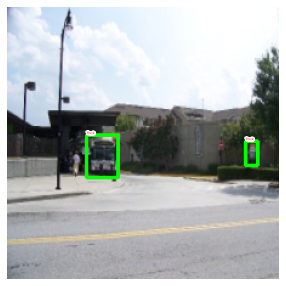

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


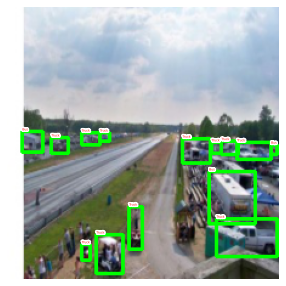

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


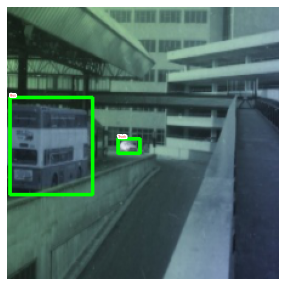

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


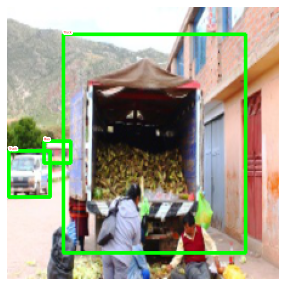

[[0.338125 0.271107 0.721875 0.831144]]

[[0.       0.163697 0.908125 0.430958]]

[[0.       0.       0.896875 0.999066]
 [0.88875  0.374416 0.97375  0.73296 ]]

[[0.303125 0.374167 0.929375 0.911667]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


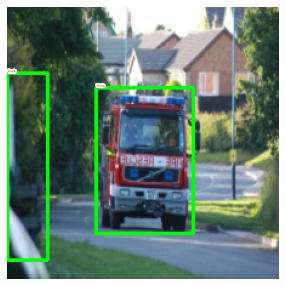

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


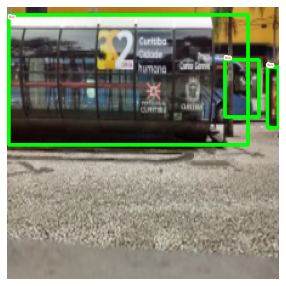

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


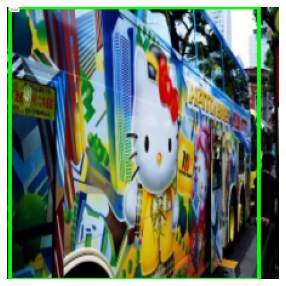

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


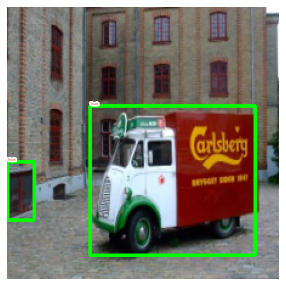

[[0.116203 0.545673 0.90671  0.997596]]

[[0.       0.3175   0.126875 0.62    ]
 [0.128125 0.36375  0.268125 0.54625 ]
 [0.24375  0.34125  0.371875 0.5175  ]
 [0.359375 0.36625  0.5075   0.475   ]]

[[0.       0.       0.468125 0.949953]]

[[0.       0.471875 0.089375 0.64625 ]
 [0.154375 0.485625 0.26375  0.601875]
 [0.268125 0.411875 0.711875 0.785625]]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


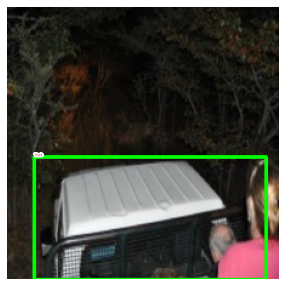

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


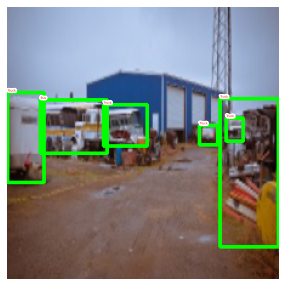

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


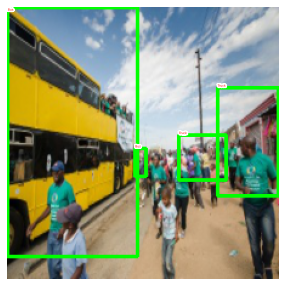

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


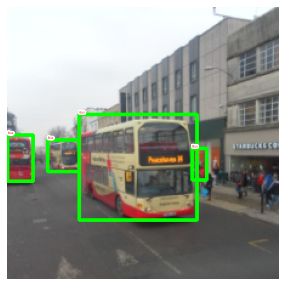

[[0.1725   0.       0.999375 0.910995]
 [0.174375 0.       0.999375 0.912042]]

[[0.       0.300833 0.640625 0.716667]
 [0.636875 0.4275   0.76875  0.5875  ]
 [0.76375  0.430833 0.95875  0.570833]]

[[0.008125 0.325843 0.150625 0.601124]]

[[0.1875   0.252083 0.892187 0.641667]]

In [20]:
model.eval()
for ix, (images, targets) in enumerate(test_loader):
    if ix == 3:
        break
    images = [im for im in images]
    outputs = model(images)
    for ix, output in enumerate(outputs):
        bbs, confs, labels = decode_output(output)
        info = [f'{l}@{c:.2f}' for l,c in zip(labels, confs)]
        show(images[ix].cpu().permute(1,2,0),bbs=bbs,texts=labels,sz=5)